## Anomaly Detection- windowed method 

In [216]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.layers import Lambda, Input, Dense, Dropout

Importing the dataset

In [217]:
data = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv",
                   parse_dates=True, index_col="timestamp")

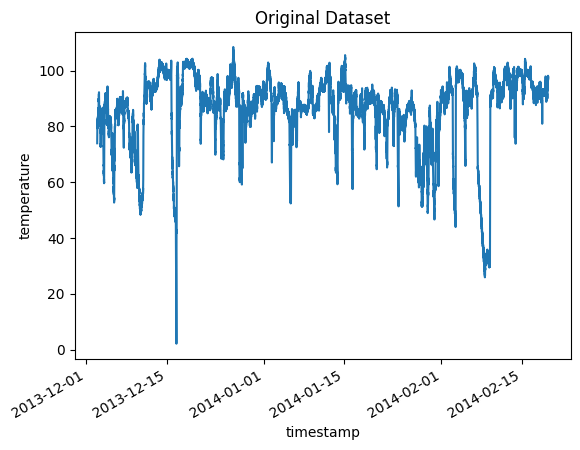

In [218]:
fig, ax = plt.subplots()
data.plot(legend=False, ax=ax)
plt.ylabel("temperature")
plt.title("Original Dataset")
plt.show()

Splitting training and testing

In [219]:
# Splitting to train and test
test_ratio =0.3
start = int(len(data) * 0.25 )  # or 0 
tr_data = data.iloc[start: int(len(data) * (1 - test_ratio))]
tst_data1 = data.iloc[int(len(data) * (1 - test_ratio)) :]
tst_data2 = data.iloc[0:start]

In [220]:
tr_data

,value
timestamp,
2013-12-22 14:00:00,87.168898
2013-12-22 14:05:00,87.933798
2013-12-22 14:10:00,85.804768
2013-12-22 14:15:00,85.955663
2013-12-22 14:20:00,86.815269
...,...
2014-01-26 23:40:00,88.470506
2014-01-26 23:45:00,88.395883
2014-01-26 23:50:00,88.608302


Normailzing the training set 

In [221]:
# Normalize and save the mean and std we get, for normalizing test data.
training_mean = tr_data.mean()
training_std = tr_data.std()
train_scaled = (tr_data - training_mean) / training_std
print("Number of training samples:", len(train_scaled))

Number of training samples: 10213


Function to create the windowed data

In [222]:
# Generated training sequences for use in the model.
def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [223]:
step_size = 288

train = create_sequences(train_scaled.values, step_size)
print("Training input shape: ", train.shape)

Training input shape:  (9926, 288, 1)


VAE model

In [224]:
# # Reparameterization trick
# def sampling(args):
#     z_mean, z_log_var = args
#     epsilon = keras.backend.random_normal(shape=(keras.backend.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
#     return z_mean + keras.backend.exp(0.5 * z_log_var) * epsilon

In [225]:
# class VAELossLayer(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(VAELossLayer, self).__init__(**kwargs)

#     def call(self, inputs):
#         x, x_decoded_mean, z_mean, z_log_var = inputs
#         # Reshape inputs to have the same shape
#         x = tf.reshape(x, tf.shape(x_decoded_mean))
#         # compute the average MSE error, then scale it up, i.e. simply sum on all axes
#         reconstruction_loss = tf.reduce_sum(tf.square(x - x_decoded_mean))
#         # compute the KL loss
#         kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
#         # return the average loss over all 
#         total_loss = tf.reduce_mean(reconstruction_loss + 0.05*kl_loss)    
#         self.add_loss(total_loss)
#         return x  # Dummy output


In [226]:
from utils.sample import sample
from model.VAELossLayer import VAELossLayer

In [227]:
class VAELossLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs
        # Reshape inputs to have the same shape
        x = tf.reshape(x, tf.shape(x_decoded_mean))
        # compute the average MSE error, then scale it up, i.e. simply sum on all axes
        reconstruction_loss = tf.reduce_sum(tf.square(x - x_decoded_mean))
        # compute the KL loss
        kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        # return the average loss over all 
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)    
        self.add_loss(total_loss)
        return x  # Dummy output



In [228]:
# Define VAE loss function
def vae_loss(x, x_decoded_mean, z_mean, z_log_var):
    # Reshape inputs to have the same shape
    x = tf.reshape(x, tf.shape(x_decoded_mean))
    
    # Compute reconstruction loss
    reconstruction_loss = tf.reduce_sum(tf.square(x - x_decoded_mean))
    
    # Compute KL divergence
    kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    
    # Combine reconstruction loss and KL divergence
    total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    
    return total_loss

# Encoder
latent_dim = 8  # Dimensionality of the latent space
encoder_inputs = Input(shape=(train.shape[1], train.shape[2]))
x = layers.Conv1D(
    filters=32,
    kernel_size=7,
    padding="same",
    strides=2,
    activation="relu",
)(encoder_inputs)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv1D(
    filters=16,
    kernel_size=7,
    padding="same",
    strides=2,
    activation="relu",
)(x)
x = layers.Flatten()(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)

# Use Lambda layer to sample from the latent distribution
z = layers.Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Instantiate encoder model
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = Input(shape=(latent_dim,))
x = Dense(train.shape[1]*16, activation='relu')(latent_inputs)
x = layers.Reshape((int(train.shape[1]/4), 64))(x)  # Adjusted reshape operation
x = layers.Conv1DTranspose(
    filters=32,
    kernel_size=7,
    padding="same",
    strides=2,
    activation="relu",
)(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv1DTranspose(
    filters=16,
    kernel_size=7,
    padding="same",
    strides=2,
    activation="relu",
)(x)
decoder_outputs = layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")(x)


# Instantiate decoder model
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Instantiate VAE model
outputs = decoder(encoder(encoder_inputs)[2])



vae_loss_layer = VAELossLayer()([encoder_inputs, outputs, z_mean, z_log_var])

#vae = keras.Model(encoder_inputs, outputs, name="vae")
vae = keras.Model(encoder_inputs, [outputs, vae_loss_layer], name='vae')

vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [229]:
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 288, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 144, 32)   │        256 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 144, 32)   │          0 │ conv1d_18[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 72, 16)    │      3,600 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 8),       │     22,304 │ input_layer_18[0… │
│ (Functional)        │ (None, 8), (None, │            │                   │
│                     │ 8)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 1152)      │          0 │ conv1d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 288, 1)    │     59,553 │ encoder[0][2]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │      9,224 │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │      9,224 │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer_8    │ (None, 288, 1)    │          0 │ input_layer_18[0… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 81,857 (319.75 KB)

 Trainable params: 81,857 (319.75 KB)

 Non-trainable params: 0 (0.00 B)

In [230]:
# model = keras.Sequential(
#     [
#         layers.Input(shape=(train.shape[1], train.shape[2])),
#         layers.Conv1D(
#             filters=32,
#             kernel_size=7,
#             padding="same",
#             strides=2,
#             activation="relu",
#         ),
#         layers.Dropout(rate=0.2),
#         layers.Conv1D(
#             filters=16,
#             kernel_size=7,
#             padding="same",
#             strides=2,
#             activation="relu",
#         ),
#         layers.Conv1DTranspose(
#             filters=16,
#             kernel_size=7,
#             padding="same",
#             strides=2,
#             activation="relu",
#         ),
#         layers.Dropout(rate=0.2),
#         layers.Conv1DTranspose(
#             filters=32,
#             kernel_size=7,
#             padding="same",
#             strides=2,
#             activation="relu",
#         ),
#         layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
#     ]
# )
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
# model.summary()


In [231]:
history = vae.fit(
    train,
    train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])

Epoch 1/50


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 29412.7559 - val_loss: 13689.7588
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7662.2422 - val_loss: 5361.7393
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3717.7332 - val_loss: 3534.7849
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2783.8694 - val_loss: 2999.5830
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2392.5703 - val_loss: 2426.5381
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2111.7812 - val_loss: 2489.3179
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1950.4528 - val_loss: 2453.5955
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1820.2189 - val_loss: 3053.5942
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1736.1886 - val_loss: 2713.0591
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1652.2488 - val_loss: 2548.7913
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1581.2639 - val_loss: 2991.9045
Epoch 

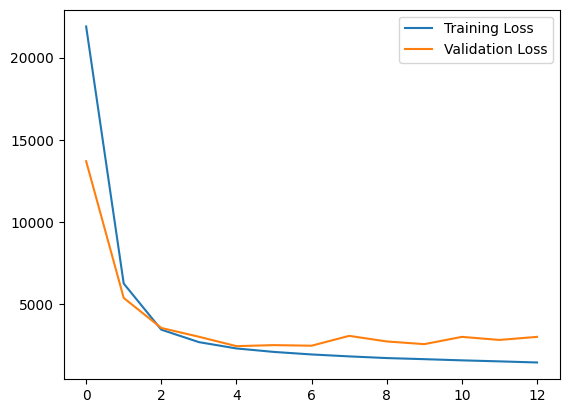

In [232]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
(9926, 1)


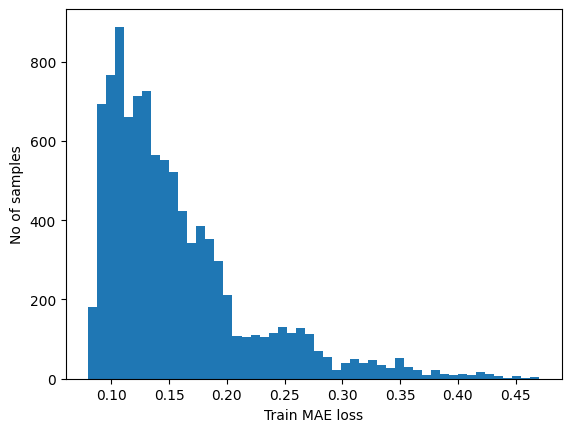

Reconstruction error threshold:  0.47036445654028075


In [233]:
# Get train MAE loss.
train_pred = vae.predict(train)[0]
train_mae_loss = np.mean(np.abs(train_pred - train), axis=1)
print(train_mae_loss.shape)
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [234]:
print(train_pred.shape)

(9926, 288, 1)


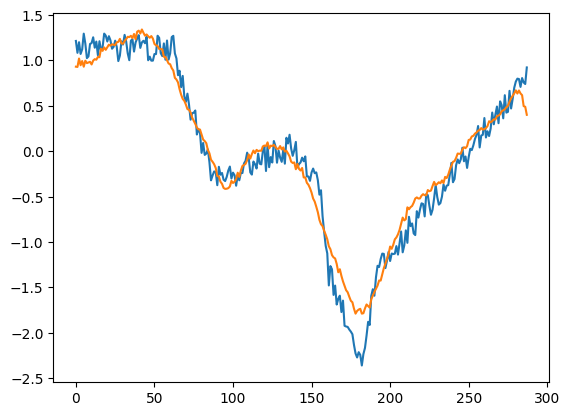

In [235]:
# Checking how the first sequence is learnt
plt.plot(train[90])
plt.plot(train_pred[90])
plt.show()

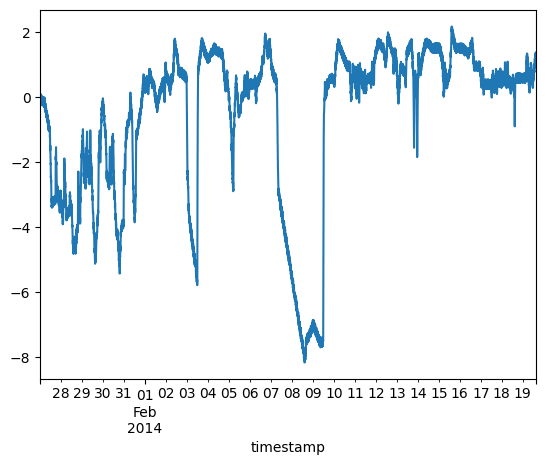

Test input shape:  (6522, 288, 1)
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(6522, 1)


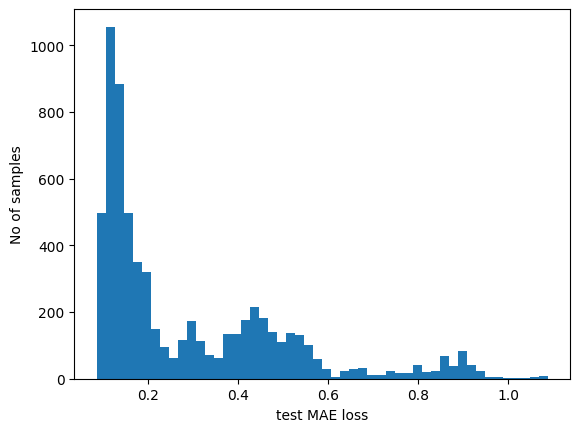

Number of anomaly samples:  1204
Indices of anomaly samples:  (array([ 129,  130,  131, ..., 3820, 3821, 3822], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64))


In [236]:

tst_data= tst_data1          #1 or 2
test_scaled = (tst_data - training_mean) / training_std
fig, ax = plt.subplots()
test_scaled.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
test = create_sequences(test_scaled.values, step_size)
print("Test input shape: ", test.shape)

# Get test MAE loss.
test_pred = vae.predict(test)[0]
test_mae_loss = np.mean(np.abs(test_pred - test), axis=1)
print(test_mae_loss.shape)
#test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [238]:
# anomalous_data_indices = []
# for ind in range(len(anomalies)):
#     if anomalies[ind]:
#         anomalous_data_indices.append(ind)

In [260]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
step_size = 288
anomalous_data_indices = []
for data_idx in range(step_size - 1, len(test_scaled) - step_size + 1):
    if np.all(anomalies[data_idx - step_size + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [261]:
print("Indices of anomalies: ", anomalous_data_indices)

Indices of anomalies:  [3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602

In [253]:
data['label'] = 1
instances= [["2013-12-10 06:25:00","2013-12-12 05:35:00"],
            ["2013-12-15 17:50:00","2013-12-17 17:00:00"],
            ["2014-01-27 14:20:00","2014-01-29 13:30:00"],
            ["2014-02-07 14:55:00","2014-02-09 14:05:00"]]


In [254]:
df_subset = tst_data.iloc[anomalous_data_indices]
df_subset

,value
timestamp,
2014-02-07 22:45:00,46.417969
2014-02-07 22:50:00,48.161737
2014-02-07 22:55:00,46.943378
2014-02-07 23:00:00,47.164435
2014-02-07 23:05:00,46.133651
...,...
2014-02-09 06:20:00,32.111134
2014-02-09 06:25:00,31.856606
2014-02-09 06:30:00,31.962661


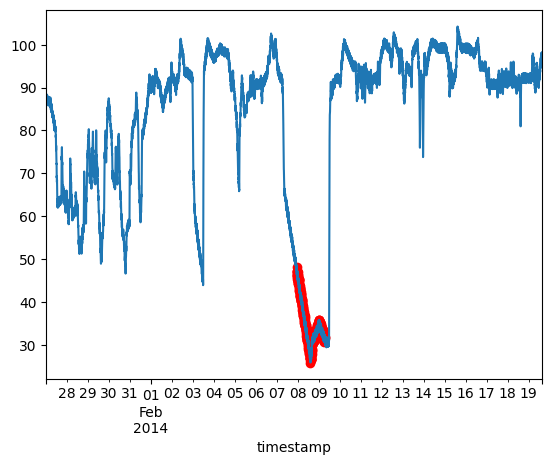

In [255]:
fig, ax = plt.subplots()
tst_data.plot(legend=False, ax=ax)
ax.scatter(df_subset.index, df_subset['value'], color="r")
plt.show()